In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
from configparser import ConfigParser
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import sys
from PIL import Image
from glob import glob
import pickle
from pathlib import Path
import json
import gc

In [3]:
!pip install opencv-python


In [4]:
import cv2
import sys 
sys.path.append("src/")

In [5]:
from utilities import (
    resize_pad, sim_resize, resize, show_sbs, clean_nuc_mask,
    crop_multi_scale_submats, do_cyto_pred_process, 
    get_pure_img_bbox, get_cyto_mask, 
    do_cyto_postprocess, get_biggest_cc_msk
)

In [6]:
import json
from pathlib import Path
CONFIG_FILE_PATH = 'config.json'

In [7]:
with open(CONFIG_FILE_PATH, "r") as fp:
    config = json.load(fp)

Path(config['DATA']['NPY_DIR']).mkdir(parents=True, exist_ok=True)

run_name = config['RUN']['name']
imsk_fn = config['RUN']['imsk_folder_name']
final_imsk_fn = config['RUN']['final_imsk_folder_name']

 

Path("results/").mkdir(parents=True, exist_ok=True)
Path("results/run_{}".format(run_name)).mkdir(parents=True, exist_ok=True)
Path("results/run_{}/{}".format(run_name, imsk_fn)).mkdir(parents=True, exist_ok=True)
Path("results/run_{}/{}".format(run_name, final_imsk_fn)).mkdir(parents=True, exist_ok=True)
Path("results/run_{}/{}/filtered".format(run_name, imsk_fn)).mkdir(parents=True, exist_ok=True)

 

IMSK_DIR   = "results/run_{}/{}/".format(run_name, imsk_fn)
F_IMSK_DIR = "results/run_{}/{}/filtered/".format(run_name, imsk_fn)

 

CROP_SCALE_LIST = config['RUN']['crop_scale_list']
for sc in CROP_SCALE_LIST+[0,]:
    Path('{}sc_{:1.2f}'.format(  IMSK_DIR, sc)).mkdir(parents=True, exist_ok=True)
    Path('{}sc_{:1.2f}'.format(F_IMSK_DIR, sc)).mkdir(parents=True, exist_ok=True)

In [8]:
DATA_CFG = config['DATA']

X_path_list = glob('{}*{}'.format(config['DATA']['X_DIR'], config['DATA']['X_FILE_TYPE_EXTENSION']))

X = []
X_org = []
X_names = []
X_shapes = []
for xp in tqdm(X_path_list):
    fn = xp.split('/')[-1].split('.')[0]
    X_names.append(fn)
    
    img = np.array(Image.open(xp))
    X_org.append(img)
    X_shapes.append(img.shape)
    
    img_ = resize(img, tuple(config['NUCS']['MODEL']['input_shape'][:2]), interpolation='linear')
    X.append(img_)
    

X = np.array(X)
np.save(config['DATA']['NPY_DIR']+'X_nuc', X.astype(np.uint8))

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 45.50it/s]


In [9]:
import keras
import tensorflow

2023-10-27 11:10:54.200399: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-27 11:10:54.301561: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ec2-user/anaconda3/lib/python3.7/site-packages/cv2/../../lib64:/opt/amazon/efa/lib64:/opt/amazon/openmpi/lib64:/opt/aws-ofi-nccl/lib:/usr/local/cuda/lib:/usr/local/cuda:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/targets/x86_64-linux/lib:/usr/local/lib:/usr/lib:/lib
2023-10-27 11:10:54.301586: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] I

In [10]:
from models.model_nuc import unet_dnspro as NucModel

In [11]:
!pip install keras==2.2.0
!pip install tensorflow

  Using cached Keras-2.2.0-py2.py3-none-any.whl (300 kB)
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires keras<2.12,>=2.11.0, but you have keras 2.2.0 which is incompatible.
  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: Keras 2.2.0
    Uninstalling Keras-2.2.0:
      Successfully uninstalled Keras-2.2.0


In [12]:
nuc_model = NucModel(**config['NUCS']['MODEL'])

2023-10-27 11:11:00.853185: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-27 11:11:00.853389: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ec2-user/anaconda3/lib/python3.7/site-packages/cv2/../../lib64:/opt/amazon/efa/lib64:/opt/amazon/openmpi/lib64:/opt/aws-ofi-nccl/lib:/usr/local/cuda/lib:/usr/local/cuda:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/targets/x86_64-linux/lib:/usr/local/lib:/usr/lib:/lib
2023-10-27 11:11:00.853441: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared obje

In [13]:
from keras import backend as K

1/1 [==============================] - 5s 5s/step


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 13.66it/s]
/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.92it/s]
/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


101


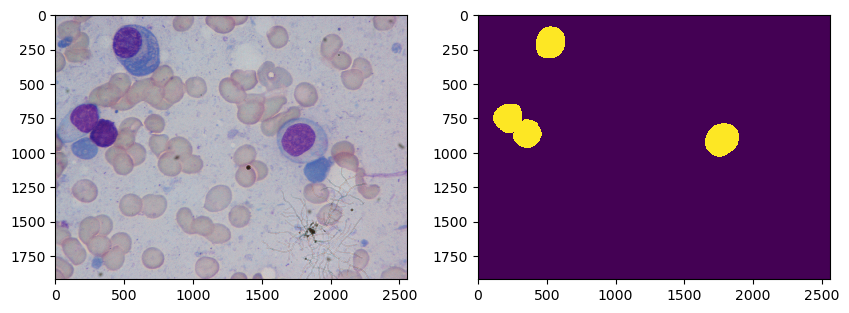

In [14]:
prediction = nuc_model.predict(np.array(X/255.), verbose=1)
prediction = np.squeeze(prediction)

del nuc_model
for i in range(5):
    gc.collect()
    K.clear_session()

nuc_preds = []
for i in tqdm(range(len(prediction))):
    mask = np.where(prediction[i]>config['NUCS']['bth'], 1, 0)
    cleaned_mask = clean_nuc_mask(mask)
    nuc_preds.append(resize((255*cleaned_mask).astype(np.uint8), tuple(X_shapes[i][:2]), 'linear'))
nuc_preds = np.array(nuc_preds)/255.

threshold = config['NUCS']['bth']
nuc_pred_masks = []

for i in tqdm(range(len(nuc_preds))):
    mask = np.where(nuc_preds[i] > threshold, 1, 0)
    cleaned_mask = clean_nuc_mask(mask)
    thresholded_mask = (255 * cleaned_mask).astype(np.uint8)
    resized_mask = resize(thresholded_mask, tuple(X_shapes[i][:2]), 'linear')
    nuc_pred_masks.append(resized_mask)

nuc_pred_masks = np.array(nuc_pred_masks)

print(X_names[0])
show_sbs(X_org[0], nuc_pred_masks[0])

In [15]:
X_org_pp_ch4 = []

for i in tqdm(range(len(X_org))):
    x, nm = X_org[i], nuc_pred_masks[i]
    
    # Iterate over color channels (0, 1, 2)
    for ch in range(3):
        x[:,:,ch] = cv2.equalizeHist(np.uint8(x[:,:,ch]))
    
    x = np.concatenate([x, np.expand_dims(nm, -1)], -1)        
    X_org_pp_ch4.append(x)
    
X = np.array(X_org_pp_ch4)
M = np.array(nuc_pred_masks)

print(X.shape, M.shape)


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 17.69it/s]

(3,) (3,)



/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]


In [16]:
scales_cropped_data = []
for scale in CROP_SCALE_LIST:
    scale_cropped_data = []
    for i in tqdm(range(len(X_names)), desc='Scale:{:2.2f}'.format(scale)):
        mask, image, name = nuc_pred_masks[i], X[i], X_names[i]
        cropped_nucs_data = crop_multi_scale_submats(image, name, mask, [scale])
        scale_cropped_data.append(cropped_nucs_data)
    scales_cropped_data.append(scale_cropped_data)
    

Scale:3.00: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.11it/s]


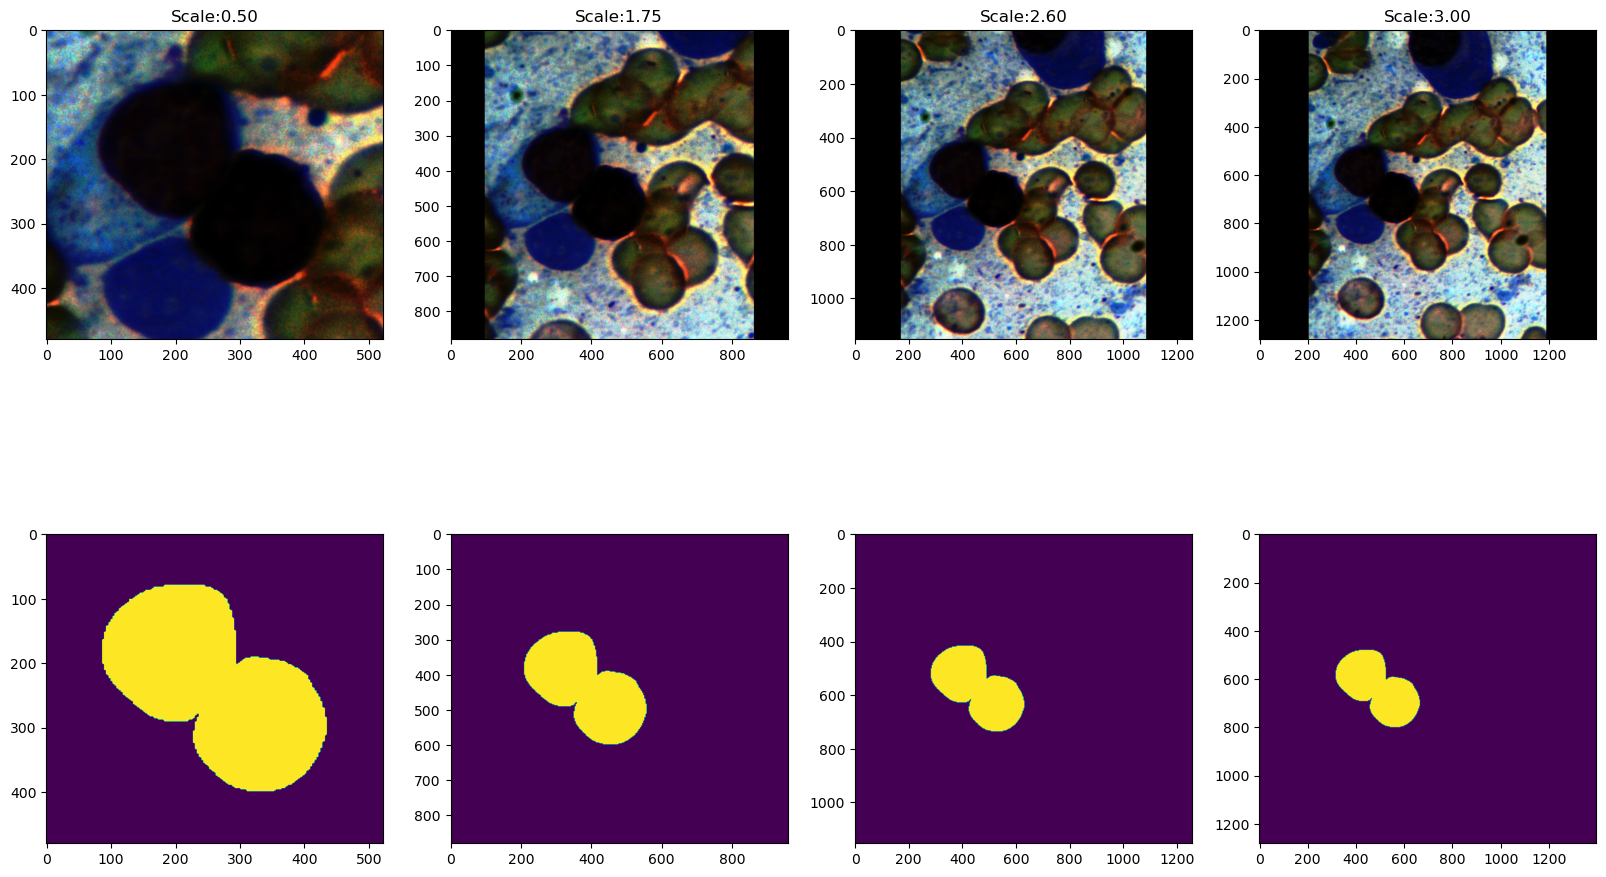

In [17]:
_, axs = plt.subplots(2, len(scales_cropped_data), figsize=(len(scales_cropped_data)*5, 12))
for i, scale_cropped_data in enumerate(scales_cropped_data):
    tmp = 1
    simg = scale_cropped_data[0]['data'][tmp][0]['simg']
    snmsk = scale_cropped_data[0]['data'][tmp][0]['snmsk']
    axs[0, i].imshow(simg[:,:,:3])
    axs[0, i].set_title('Scale:{:1.2f}'.format(CROP_SCALE_LIST[i]))
    axs[1, i].imshow(snmsk)
plt.show()

In [18]:
from models.model_cyt import Deeplabv3pa as CytModel

In [19]:
CFG = config['CYTS']['MODELS']
cyts_preds_scales = []
for scale, scale_cropped_data in zip(CROP_SCALE_LIST, scales_cropped_data):
    
    model_conf = {
        'input_shape': CFG['input_shape_micro'] if scale<CFG['micro_macro_sc_th'] else CFG['input_shape_micro'],
        'pretrained_weights': CFG['sc{:1.2f}_weights'.format(scale)]
    }
    model_scale_params = {
        'binary_th': CFG['sc{:1.2f}_bth_ks'.format(scale)][0],
        'KS'       : CFG['sc{:1.2f}_bth_ks'.format(scale)][1]
    }
    cyt_model = CytModel(**model_conf)

    pred_mask_nucs_cyto = []
    for data in tqdm(scale_cropped_data, desc='Scale:{:1.2f}'.format(scale)):
        preds_cyto_on_sub = data    
        for i, ins in enumerate(preds_cyto_on_sub['data']):
            for j, ins_scale in enumerate(ins):
                x = ins_scale['simg']
                x_shape = x.shape

                x = resize_pad(x, tuple(model_conf['input_shape'][:2]))
                x[:,:,3] = np.where(x[:,:,3]>127, 255, 0)
                bbox = get_pure_img_bbox(x)
                
                pred_cyto = cyt_model.predict(np.array([x/255]), batch_size=1, verbose=0)
                pred_cyto = np.squeeze(pred_cyto)
                ppred_cyto = do_cyto_pred_process(pred_cyto)
                mask_cyto = get_cyto_mask(ppred_cyto, model_scale_params['binary_th'])
                mask_cyto_ = do_cyto_postprocess(mask_cyto, model_scale_params['KS'])
                mask_cyto_ = get_biggest_cc_msk(np.uint8(mask_cyto_))
                mask_cyto_ = mask_cyto_[bbox[0]:bbox[1],bbox[2]:bbox[3]]
                preds_cyto_on_sub['data'][i][j]['scmsk'] = mask_cyto_
        pred_mask_nucs_cyto.append(preds_cyto_on_sub)
    
    del cyt_model
    for i in range(5):
        gc.collect()
        K.clear_session()
        
    cyts_preds_scales.append(pred_mask_nucs_cyto)

Scale:3.00: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.74s/it]


In [20]:
cyts_preds_scales

[[{'meta': {'image_size': (1920, 2560, 4),
    'image_name': '101',
    'total_insts': 3},
   'data': [[{'scale': 0.5,
      'bbox': [31, 365, 380, 688],
      'bbox_hint': '[x_min, y_min, x_max, y_max]',
      'shift': [0, 0],
      'simg_size': (349, 323),
      'simg': array([[[128, 107, 117,   0],
              [128, 107, 117,   0],
              [121, 107, 124,   0],
              ...,
              [104, 129, 159,   0],
              [ 93, 124, 174,   0],
              [ 98, 129, 191,   0]],
      
             [[121, 104, 112,   0],
              [121, 107, 124,   0],
              [109, 100, 145,   0],
              ...,
              [ 87, 135, 205,   0],
              [ 87, 135, 205,   0],
              [ 78, 124, 174,   0]],
      
             [[115, 100, 104,   0],
              [121, 107, 124,   0],
              [109,  94, 107,   0],
              ...,
              [109, 141, 174,   0],
              [ 98, 129, 145,   0],
              [104, 135, 159,   0]],
      
    

In [21]:
import numpy as np
import cv2
import os

# Define the base directory for saving the combined images
base_dir = IMSK_DIR

# Initialize a dictionary to store combined results for each scale and prefix
combined_results = {}

for pred_masks_nucs_cyto, scale in zip(cyts_preds_scales, CROP_SCALE_LIST):
    # Create a directory for the current scale if it doesn't exist
    scale_dir = os.path.join(base_dir, f'sc_{scale:1.2f}')
    os.makedirs(scale_dir, exist_ok=True)

    for data in tqdm(pred_masks_nucs_cyto, desc='Scale:{:1.2f}'.format(scale)):
        preds_cyto_on_sub = data
        meta = preds_cyto_on_sub['meta']

        # Initialize combined_result after meta is declared
        combined_result = np.zeros(meta['image_size'][:2], dtype=np.uint8)

        idx = 1
        for i, ins in enumerate(preds_cyto_on_sub['data']):
            for j, ins_scale in enumerate(ins):
                simg = ins_scale['simg']
                snmsk = ins_scale['snmsk']
                scmsk = ins_scale['scmsk']
                bbox = ins_scale['bbox']
                pure_bbox = get_pure_img_bbox(simg)
                b = pure_bbox
                try:
                    pure_simg = simg[b[0]:b[1], b[2]:b[3]]
                    pure_snmsk = snmsk[b[0]:b[1], b[2]:b[3]]
                    pure_scmsk = sim_resize(scmsk, (bbox[2] - bbox[0], bbox[3] - bbox[1]))
                    pure_smsk = np.where((pure_snmsk > 0) | (pure_scmsk > 0), 20, 0)
                    pure_smsk = pure_smsk + np.where(pure_snmsk > 0, 20, 0)
                    idxs, idys = np.where(pure_snmsk > 0)
                    pure_smsk[idxs[0], idys[0]] = 20
                except:
                    print(meta['image_name'], idx)
                    continue
                for u in np.unique(pure_smsk):
                    if u not in [0, 20, 40]:
                        print('Ops... image:', meta['image_name'], 'unique:', np.unique(pure_smsk))
                
                # Overlay the processed nucleus cell mask on the combined_result
                combined_result[bbox[0]:bbox[2], bbox[1]:bbox[3]] += pure_smsk.astype(np.uint8)

                idx += 1

        # Save the combined result for the current scale and prefix
        combined_results[(scale, meta['image_name'])] = combined_result

# Save the final combined results as bitmap images for each scale and prefix
for (scale, image_prefix), combined_result in combined_results.items():
    # Create a directory for the current scale if it doesn't exist
    fn = os.path.join(IMSK_DIR, 'sc_{:1.2f}'.format(scale), '{}_combined.bmp'.format(image_prefix))
    cv2.imwrite(fn, combined_result)


Scale:3.00: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.22it/s]


In [22]:
import numpy as np
import cv2
import os

# Define the base directory for saving the combined images
base_dir = IMSK_DIR

# Initialize a dictionary to store combined results for each scale and prefix
combined_results = {}

for data in tqdm(pred_masks_nucs_cyto, desc='Scale:{:1.2f}'.format(0.00)):
    preds_cyto_on_sub = data
    meta = preds_cyto_on_sub['meta']
    scale = 0.00

    # Create a directory for the current scale if it doesn't exist
    scale_dir = os.path.join(base_dir, f'sc_{scale:1.2f}')
    os.makedirs(scale_dir, exist_ok=True)

    idx = 1
    for i, ins in enumerate(preds_cyto_on_sub['data']):
        for j, ins_scale in enumerate(ins):
            simg = ins_scale['simg']
            snmsk = ins_scale['snmsk']
            scmsk = ins_scale['scmsk']
            bbox = ins_scale['bbox']
            pure_bbox = get_pure_img_bbox(simg)
            b = pure_bbox
            try:
                pure_simg = simg[b[0]:b[1], b[2]:b[3]]
                pure_snmsk = snmsk[b[0]:b[1], b[2]:b[3]]
                pure_smsk = np.where(pure_snmsk > 0, 40, 0)
                pure_smsk[:, 4:] = pure_smsk[:, :-4]
                idxs, idys = np.where(pure_snmsk > 0)
                pure_smsk[idxs[0], idys[0]] = 20
            except:
                print(meta['image_name'], idx)
                continue
            for u in np.unique(pure_smsk):
                if u not in [0, 20, 40]:
                    print('Ops... image:', meta['image_name'], 'unique:', np.unique(pure_smsk))

            # Overlay the processed nucleus cell mask on the combined_result
            combined_result = np.zeros(meta['image_size'][:2], dtype=np.uint8)
            combined_result[bbox[0]:bbox[2], bbox[1]:bbox[3]] = pure_smsk.astype(np.uint8)

            idx += 1

    # Save the combined result for the current scale and prefix
    combined_results[(scale, meta['image_name'])] = combined_result

# Save the final combined results as bitmap images for each scale and prefix
for (scale, image_prefix), combined_result in combined_results.items():
    fn = os.path.join(IMSK_DIR, 'sc_{:1.2f}'.format(scale), '{}_combined.bmp'.format(image_prefix))
    cv2.imwrite(fn, combined_result)


Scale:0.00: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.77it/s]


In [23]:
for scale in [0,]+CROP_SCALE_LIST:
    THS = config["FILTERS"]["sc{:1.2f}".format(scale)] if scale > 0 else [0, 200]
    SOURCE_DIR  = '{}sc_{:1.2f}/'.format(  IMSK_DIR, scale)
    REFINED_DIR = '{}sc_{:1.2f}/'.format(F_IMSK_DIR, scale)
    total = 0.
    refined = 0.
    rejected = 0.
    file_path_list = glob(SOURCE_DIR+'*.bmp')
    img_name_list = set([p.split('/')[-1].split('_')[0] for p in file_path_list])
    bar = tqdm(img_name_list, desc='Scale:{:1.2f}'.format(scale))
    for name in bar:    
        imsk_path_list = glob(SOURCE_DIR+name+'_*.bmp')
        idx = 0
        for imp in imsk_path_list:
            total += 1
            imsk = np.asarray(Image.open(imp))
            nuc_area = np.where(imsk==40, 1, 0).sum()
            cyt_area = np.where(imsk==20, 1, 0).sum()
            cyt_to_nuc_ratio = 1.*cyt_area/nuc_area
            if  cyt_to_nuc_ratio > THS[1] or THS[0] > cyt_to_nuc_ratio :
                rejected += 1.
            else:
                idx += 1
                res = Image.fromarray(imsk.astype(np.uint8))
                save_name = '{}{}_{}.bmp'.format(REFINED_DIR, name, idx)
                res.save(save_name)
        bar.set_description('Rejected:{:04.0f}/{:04.0f} ({:2.3f})%'.format(rejected, total, 100.*rejected/total))

Rejected:0003/0003 (100.000)%: 100%|██████████████████████████████████████████████████████| 3/3 [00:00<00:00, 47.37it/s]


In [24]:
FILE_TYPE_EXTENSION = '.bmp'
TEST_DATA_X_DIR = config["DATA"]["X_DIR"]
TOTAL_PREDICTION_DIR = 'results/run_{}/{}/'.format(run_name, final_imsk_fn)
predictions_list = ['{}sc_{:1.2f}/'.format(F_IMSK_DIR, scale) for scale in CROP_SCALE_LIST]
predictions = []
for prediction_dir in predictions_list:
    predictions += glob('{}*{}'.format(prediction_dir, FILE_TYPE_EXTENSION))
test_x = glob(TEST_DATA_X_DIR + '*' + FILE_TYPE_EXTENSION)
for tfp in tqdm(test_x):
    fn = tfp.split('/')[-1].split(FILE_TYPE_EXTENSION)[0]
    preds = [p for p in predictions if '/'+fn+'_' in p]
    if len(preds):
        cnt = 1
        for pp in preds:
            new_path = TOTAL_PREDICTION_DIR + fn + '_' + str(cnt) + FILE_TYPE_EXTENSION
            os.system("cp {} {}".format(pp, new_path))
            cnt += 1
    else:
        print('There is no prediciton for the file <{}>'.format(fn+FILE_TYPE_EXTENSION))

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 13.92it/s]


In [25]:
import cv2
import os


mask_directory = 'results/run_dns/final_imsk/'
output_directory = 'results/run_dns/combined_images/'


os.makedirs(output_directory, exist_ok=True)


common_prefixes = set()
for filename in os.listdir(mask_directory):
    if filename.endswith(".bmp"):
        prefix = filename.split("_")[0]
        common_prefixes.add(prefix)


for common_image_prefix in common_prefixes:
    
    segmented_images = []

    
    for filename in os.listdir(mask_directory):
        if filename.startswith(common_image_prefix) and filename.endswith(".bmp"):
            image_path = os.path.join(mask_directory, filename)

            
            segmented_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            segmented_images.append(segmented_image)

    
    combined_image = cv2.add(segmented_images[0], segmented_images[1])
    for i in range(2, len(segmented_images)):
        combined_image = cv2.add(combined_image, segmented_images[i])

    
    output_path = os.path.join(output_directory, f"{common_image_prefix}_combined.bmp")
    cv2.imwrite(output_path, combined_image)




In [26]:
import os
import cv2
import numpy as np
from skimage import measure


input_directory = 'results/run_dns/final_imsk/'
output_directory = 'results/run_dns/processed/'


os.makedirs(output_directory, exist_ok=True)


for filename in os.listdir(input_directory):
    if filename.endswith(".bmp"):
        
        input_path = os.path.join(input_directory, filename)
        image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)

        
        cytoplasm_threshold = 20  

        
        cytoplasm_mask = (image >= cytoplasm_threshold).astype(np.uint8)

        
        cytoplasm_labels = measure.label(cytoplasm_mask, connectivity=2)

        
        cytoplasm_regions = measure.regionprops(cytoplasm_labels)

        
        cytoplasm_colored = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)

        
        cytoplasm_color = [0, 0, 255] 
        for region in cytoplasm_regions:
            for coord in region.coords:
                cytoplasm_colored[coord[0], coord[1]] = cytoplasm_color

        
        nuclei_mask = (image >= 35).astype(np.uint8)  
        nuclei_color = [255, 255, 255]  
        cytoplasm_colored[nuclei_mask > 0] = nuclei_color  

        
        output_path = os.path.join(output_directory, filename)
        cv2.imwrite(output_path, cytoplasm_colored)


In [27]:
import cv2
import numpy as np
import os
 
input_dir = 'results/run_dns/processed/'
output_dir = 'results/run_dns/final_processed/'
 
os.makedirs(output_dir, exist_ok=True)
  
lower_red = np.array([0, 0, 100])
upper_red = np.array([100, 100, 255])
 
gray_color = (128, 128, 128)
 
red_color = (0, 0, 255)
 
for filename in os.listdir(input_dir):
    if filename.endswith('.bmp'):
        
        image_path = os.path.join(input_dir, filename)
        image = cv2.imread(image_path)
 
        
        cytoplasm_mask = cv2.inRange(image, lower_red, upper_red)
 
        
        result = image.copy()
 
        
        result[np.where(cytoplasm_mask > 0)] = gray_color
 
        
        cytoplasm_contours, _ = cv2.findContours(cytoplasm_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
 
        
        for contour in cytoplasm_contours:
            cv2.drawContours(result, [contour], -1, red_color, thickness=3)
 
        
        output_path = os.path.join(output_dir, filename)
        cv2.imwrite(output_path, result)

In [28]:
import cv2
import numpy as np
import os
import glob
from skimage import measure

# Specify the input and output directories
input_directory = 'results/run_dns/final_imsk/'
output_directory = 'results/run_dns/final_distinct/'

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Define the processing code as a function
def process_image(image):
    # Define the threshold for nucleus (40)
    nucleus_threshold = 80

    # Create a binary mask for nucleus regions above the threshold
    nucleus_mask = (image == nucleus_threshold).astype(np.uint8)

    # Find contours of the nucleus regions
    nucleus_contours, _ = cv2.findContours(nucleus_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a copy of the original image for nucleus visualization
    nucleus_colored = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Outline all the nucleus regions in red
    for contour in nucleus_contours:
        cv2.drawContours(nucleus_colored, [contour], -1, (255, 0, 0), thickness=3)

    # Define a threshold value to separate different shades for cytoplasm
    cytoplasm_threshold = 21  # Adjust this threshold as needed for cytoplasm

    # Create a binary mask for the regions from the first code block
    exclude_mask = (image >= cytoplasm_threshold).astype(np.uint8)

    # Create a binary mask for cytoplasmic regions in the second code block
    cytoplasm_mask = (image >= 20).astype(np.uint8)

    # Label connected components for cytoplasm
    cytoplasm_labels = measure.label(cytoplasm_mask, connectivity=2)

    # Create a blank image for cytoplasm visualization
    cytoplasm_colored = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Set the outline color (green) for the cytoplasmic region
    outline_color = [0, 255, 0]  # Green color

    # Increase contour thickness for the green outline
    thickness = 10  # Adjust the thickness as needed
    kernel = np.ones((thickness, thickness), np.uint8)  # Increase thickness here
    cytoplasm_mask_dilated = cv2.dilate(cytoplasm_mask, kernel, iterations=1)

    # Subtract the original mask to get the thicker contour
    cytoplasm_contour = cytoplasm_mask_dilated - cytoplasm_mask

    # Initialize a flag to check if cytoplasm is present
    cytoplasm_present = False

    # Check if there is any cytoplasm
    if cytoplasm_labels.max() > 0:
        cytoplasm_present = True

    # Draw a green contour around the cytoplasm regions without filling
    if cytoplasm_present:
        for region in measure.regionprops(cytoplasm_labels):
            for coord in region.coords:
                x, y = coord[0], coord[1]
                # Exclude regions from the first code block
                if exclude_mask[x, y] == 0:
                    if x > 0 and x < cytoplasm_colored.shape[0] - 1 and y > 0 and y < cytoplasm_colored.shape[1] - 1:
                        if (
                            not cytoplasm_mask[x - 1, y]
                            or not cytoplasm_mask[x + 1, y]
                            or not cytoplasm_mask[x, y - 1]
                            or not cytoplasm_mask[x, y + 1]
                        ):
                            cytoplasm_colored[x, y] = outline_color

    # Combine the two images by overlaying the nucleus on the cytoplasm image
    combined_image = cv2.addWeighted(cytoplasm_colored, 1, nucleus_colored, 1, 0)

    return combined_image

# Use glob to get a list of image file paths in the input directory
image_files = glob.glob(os.path.join(input_directory, '*.bmp'))

# Process and save each image in the output directory
for image_file in image_files:
    # Load the image
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)

    # Process the image
    processed_image = process_image(image)

    # Get the file name without the path
    file_name = os.path.basename(image_file)

    # Define the output file path
    output_file = os.path.join(output_directory, file_name)

    # Save the processed image
    cv2.imwrite(output_file, processed_image)

# Display or save the processed images as needed


In [ ]:
for pred_masks_nucs_cyto, scale in zip(cyts_preds_scales, CROP_SCALE_LIST):
    for data in tqdm(pred_masks_nucs_cyto, desc='Scale:{:1.2f}'.format(scale)):
        preds_cyto_on_sub = data
        meta = preds_cyto_on_sub['meta']
        idx = 1
        for i, ins in enumerate(preds_cyto_on_sub['data']):    
            for j, ins_scale in enumerate(ins):
                simg  = ins_scale['simg' ]
                snmsk = ins_scale['snmsk']
                scmsk = ins_scale['scmsk']
                bbox  = ins_scale['bbox' ]
                pure_bbox = get_pure_img_bbox(simg)
                b = pure_bbox
                try:
                    pure_simg  = simg [b[0]:b[1], b[2]:b[3]]
                    pure_snmsk = snmsk[b[0]:b[1], b[2]:b[3]]
                    pure_scmsk = sim_resize(scmsk, (bbox[2]-bbox[0], bbox[3]-bbox[1]))
                    pure_smsk  = np.where((pure_snmsk>0)|(pure_scmsk>0), 20, 0) 
                    pure_smsk  = pure_smsk + np.where(pure_snmsk>0, 20, 0)
                    idxs, idys = np.where(pure_snmsk>0)
                    pure_smsk[idxs[0], idys[0]] = 20
                except:
                    print(meta['image_name'], idx)
                    continue
                for u in np.unique(pure_smsk):
                    if u not in [0, 20, 40]:
                        print('Ops... image:', meta['image_name'], 'unique:', np.unique(pure_smsk))
                fmask = np.zeros(meta['image_size'][:2], dtype=np.uint8)
                fmask[bbox[0]:bbox[2], bbox[1]:bbox[3]] = pure_smsk
                fn = '{}sc_{:1.2f}/{}_{}.bmp'.format(IMSK_DIR, scale, meta['image_name'], idx)
                cv2.imwrite(fn, fmask)
                idx+=1

In [ ]:
import numpy as np
import cv2
import os

# Define the base directory for saving the combined images
base_dir = IMSK_DIR

# Initialize a dictionary to store combined results for each scale and prefix
combined_results = {}

for pred_masks_nucs_cyto, scale in zip(cyts_preds_scales, CROP_SCALE_LIST):
    # Create a directory for the current scale if it doesn't exist
    scale_dir = os.path.join(base_dir, f'sc_{scale:1.2f}')
    os.makedirs(scale_dir, exist_ok=True)

    for data in tqdm(pred_masks_nucs_cyto, desc='Scale:{:1.2f}'.format(scale)):
        preds_cyto_on_sub = data
        meta = preds_cyto_on_sub['meta']

        # Initialize combined_result after meta is declared
        combined_result = np.zeros(meta['image_size'][:2], dtype=np.uint8)

        idx = 1
        for i, ins in enumerate(preds_cyto_on_sub['data']):
            for j, ins_scale in enumerate(ins):
                simg = ins_scale['simg']
                snmsk = ins_scale['snmsk']
                scmsk = ins_scale['scmsk']
                bbox = ins_scale['bbox']
                pure_bbox = get_pure_img_bbox(simg)
                b = pure_bbox
                try:
                    pure_simg = simg[b[0]:b[1], b[2]:b[3]]
                    pure_snmsk = snmsk[b[0]:b[1], b[2]:b[3]]
                    pure_scmsk = sim_resize(scmsk, (bbox[2] - bbox[0], bbox[3] - bbox[1]))
                    pure_smsk = np.where((pure_snmsk > 0) | (pure_scmsk > 0), 20, 0)
                    pure_smsk = pure_smsk + np.where(pure_snmsk > 0, 20, 0)
                    idxs, idys = np.where(pure_snmsk > 0)
                    pure_smsk[idxs[0], idys[0]] = 20
                except:
                    print(meta['image_name'], idx)
                    continue
                for u in np.unique(pure_smsk):
                    if u not in [0, 20, 40]:
                        print('Ops... image:', meta['image_name'], 'unique:', np.unique(pure_smsk))
                
                # Overlay the processed nucleus cell mask on the combined_result
                combined_result[bbox[0]:bbox[2], bbox[1]:bbox[3]] += pure_smsk.astype(np.uint8)

                idx += 1

        # Save the combined result for the current scale and prefix
        combined_results[(scale, meta['image_name'])] = combined_result

# Save the final combined results as bitmap images for each scale and prefix
for (scale, image_prefix), combined_result in combined_results.items():
    # Create a directory for the current scale if it doesn't exist
    scale_dir = os.path.join(base_dir, f'sc_{scale:1.2f}')
    os.makedirs(scale_dir, exist_ok=True)

    fn = os.path.join(scale_dir, f'combined_result_{image_prefix}.bmp')
    cv2.imwrite(fn, combined_result)

In [ ]:
import cv2
import os

# Define the directory where the individual prediction masks are located
predictions_list = ['{}sc_{:1.2f}/'.format(F_IMSK_DIR, scale) for scale in CROP_SCALE_LIST]

# Define the directory where the final aggregated prediction masks will be saved
TOTAL_PREDICTION_DIR = 'results/run_{}/{}/'.format(run_name, final_imsk_fn)

# Define the file extension for the images
FILE_TYPE_EXTENSION = '.bmp'

# Initialize an empty dictionary to group predictions by their common prefix
combined_masks = {}

# Loop through the prediction directories
for prediction_dir in predictions_list:
    prediction_files = glob('{}*{}'.format(prediction_dir, FILE_TYPE_EXTENSION))
    for prediction_file in prediction_files:
        # Extract the image name (common prefix) from the prediction file
        image_name = os.path.basename(prediction_file).split('_')[0]
        
        # Load the individual prediction mask
        prediction_mask = cv2.imread(prediction_file, cv2.IMREAD_GRAYSCALE)

        if image_name not in combined_masks:
            # Create a new entry in the dictionary for the image
            combined_masks[image_name] = prediction_mask
        else:
            # Combine the prediction mask with the existing combined mask
            combined_masks[image_name] = cv2.add(combined_masks[image_name], prediction_mask)

# Save the combined masks directly in the final_imsk directory
for image_name, combined_mask in combined_masks.items():
    output_path = os.path.join(TOTAL_PREDICTION_DIR, f"{image_name}_combined.bmp")
    cv2.imwrite(output_path, combined_mask)

In [ ]:
import cv2
import os
import glob

# Define the directory where the individual prediction masks are located
predictions_list = ['{}sc_{:1.2f}/'.format(F_IMSK_DIR, scale) for scale in CROP_SCALE_LIST]

# Define the directory where the final aggregated prediction masks will be saved
TOTAL_PREDICTION_DIR = 'results/run_{}/{}/'.format(run_name, final_imsk_fn)

# Define the directory where the final aggregated prediction masks are located
FINAL_IMSK_DIR = 'results/run_{}/{}/'.format(run_name, final_imsk_fn)

# Define the file extension for the images
FILE_TYPE_EXTENSION = '.bmp'

# Initialize an empty dictionary to group predictions by their common prefix
combined_masks = {}

# Loop through the prediction directories
for prediction_dir in predictions_list:
    prediction_files = glob.glob('{}*{}'.format(prediction_dir, FILE_TYPE_EXTENSION))
    for prediction_file in prediction_files:
        # Extract the image name (common prefix) from the prediction file
        image_name = os.path.basename(prediction_file).split('_')[0]

        # Load the individual prediction mask
        prediction_mask = cv2.imread(prediction_file, cv2.IMREAD_GRAYSCALE)

        if image_name not in combined_masks:
            # Create a new entry in the dictionary for the image
            combined_masks[image_name] = prediction_mask
        else:
            # Combine the prediction mask with the existing combined mask
            combined_masks[image_name] = cv2.add(combined_masks[image_name], prediction_mask)

        # Delete the individual instance of the image
        os.remove(prediction_file)

# Save the combined masks directly in the final_imsk directory
for image_name, combined_mask in combined_masks.items():
    output_path = os.path.join(TOTAL_PREDICTION_DIR, f"{image_name}_combined.bmp")
    cv2.imwrite(output_path, combined_mask)

# List all files in the final_imsk directory
image_files = os.listdir(FINAL_IMSK_DIR)

# Define the string to check for in the image names
string_to_check = "_combined"

# Loop through the image files and delete those that don't contain the specified string
for image_file in image_files:
    if string_to_check not in image_file:
        file_path = os.path.join(FINAL_IMSK_DIR, image_file)
        os.remove(file_path)


In [ ]:
import cv2
import os
import glob

# Define the directory where the individual prediction masks are located
predictions_list = ['{}sc_{:1.2f}/'.format(F_IMSK_DIR, scale) for scale in CROP_SCALE_LIST]

# Define the directory where the final aggregated prediction masks will be saved
TOTAL_PREDICTION_DIR = 'results/run_{}/{}/'.format(run_name, final_imsk_fn)

# Define the directory where the final aggregated prediction masks are located
FINAL_IMSK_DIR = 'results/run_{}/{}/'.format(run_name, final_imsk_fn)

# Define the file extension for the images
FILE_TYPE_EXTENSION = '.bmp'

# Initialize an empty dictionary to group predictions by their common prefix
combined_masks = {}

# Loop through the prediction directories
for prediction_dir in predictions_list:
    prediction_files = glob.glob('{}*{}'.format(prediction_dir, FILE_TYPE_EXTENSION))
    for prediction_file in prediction_files:
        # Extract the image name (common prefix) from the prediction file
        image_name = os.path.basename(prediction_file).split('_')[0]

        # Load the individual prediction mask
        prediction_mask = cv2.imread(prediction_file, cv2.IMREAD_GRAYSCALE)

        if image_name not in combined_masks:
            # Create a new entry in the dictionary for the image
            combined_masks[image_name] = prediction_mask
        else:
            # Resize the prediction mask to match the shape of the existing combined mask
            existing_mask = combined_masks[image_name]
            if existing_mask.shape != prediction_mask.shape:
                prediction_mask = cv2.resize(prediction_mask, (existing_mask.shape[1], existing_mask.shape[0]))
            # Add the resized prediction mask to the existing combined mask
            combined_masks[image_name] = cv2.add(existing_mask, prediction_mask)

        # Delete the individual instance of the image
        os.remove(prediction_file)

# Save the combined masks directly in the final_imsk directory
for image_name, combined_mask in combined_masks.items():
    output_path = os.path.join(TOTAL_PREDICTION_DIR, f"{image_name}_combined.bmp")
    cv2.imwrite(output_path, combined_mask)



# List all files in the final_imsk directory
image_files = os.listdir(FINAL_IMSK_DIR)

# Define the string to check for in the image names
string_to_check = "_combined"

# Loop through the image files and delete those that don't contain the specified string
for image_file in image_files:
    if string_to_check not in image_file:
        file_path = os.path.join(FINAL_IMSK_DIR, image_file)
        os.remove(file_path)


In [ ]:
import cv2
import os
import glob

# Define the directory where the individual prediction masks are located
predictions_list = ['{}sc_{:1.2f}/'.format(F_IMSK_DIR, scale) for scale in CROP_SCALE_LIST]

# Define the directory where the final aggregated prediction masks will be saved
TOTAL_PREDICTION_DIR = 'results/run_{}/{}/'.format(run_name, final_imsk_fn)

# Define the directory where the final aggregated prediction masks are located
FINAL_IMSK_DIR = 'results/run_{}/{}/'.format(run_name, final_imsk_fn)

# Define the file extension for the images
FILE_TYPE_EXTENSION = '.bmp'

# Initialize an empty dictionary to group predictions by their common prefix
combined_masks = {}

# Loop through the prediction directories
for prediction_dir in predictions_list:
    prediction_files = glob.glob('{}*{}'.format(prediction_dir, FILE_TYPE_EXTENSION))
    for prediction_file in prediction_files:
        # Extract the image name (common prefix) from the prediction file
        image_name = os.path.basename(prediction_file).split('_')[0]

        # Load the individual prediction mask
        prediction_mask = cv2.imread(prediction_file, cv2.IMREAD_GRAYSCALE)

        if image_name not in combined_masks:
            # Create a new entry in the dictionary for the image
            combined_masks[image_name] = prediction_mask
        else:
            # Resize the prediction mask to match the shape of the existing combined mask
            existing_mask = combined_masks[image_name]
            if existing_mask.shape != prediction_mask.shape:
                prediction_mask = cv2.resize(prediction_mask, (existing_mask.shape[1], existing_mask.shape[0]))
            # Add the resized prediction mask to the existing combined mask
            combined_masks[image_name] = cv2.add(existing_mask, prediction_mask)

        # Delete the individual instance of the image
        os.remove(prediction_file)

# Save the combined masks directly in the final_imsk directory
for image_name, combined_mask in combined_masks.items():
    output_path = os.path.join(TOTAL_PREDICTION_DIR, f"{image_name}_combined.bmp")
    cv2.imwrite(output_path, combined_mask)

